In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np


2023-10-30 23:06:53.498344: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-30 23:06:53.545177: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-30 23:06:53.773887: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-30 23:06:53.773934: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-30 23:06:53.775051: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [3]:
(X_temp, y_temp), (X_test, y_test) = keras.datasets.mnist.load_data()
X_valid, X_train = X_temp[:5000]/255, X_temp[5000:]/255
y_valid, y_train = y_temp[:5000], y_temp[5000:]
X_test = X_test/255


In [17]:
K = keras.backend


class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate*self.factor)


In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


In [18]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])


In [19]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(
    learning_rate=1e-3), metrics=["accuracy"])
expo_lr = ExponentialLearningRate(factor=1.005)


In [20]:
history = model.fit(X_train, y_train, validation_data=(
    X_valid, y_valid), callbacks=expo_lr)


1719/1719 [==============================] - 9s 5ms/step - loss: nan - accuracy: 0.5716 - val_loss: nan - val_accuracy: 0.0958


Text(0, 0.5, 'Loss')

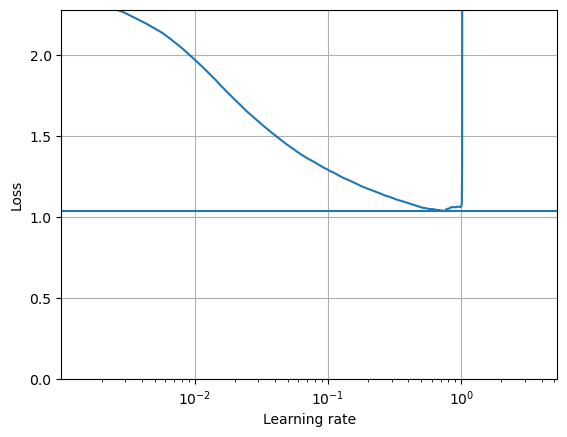

In [21]:
import matplotlib.pyplot as plt

plt.plot(expo_lr.rates, expo_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expo_lr.losses), min(expo_lr.rates), max(expo_lr.rates))
plt.axis([min(expo_lr.rates), max(expo_lr.rates), 0, expo_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")


In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(
    learning_rate=3e-1), metrics=["accuracy"])


In [23]:
import os
run_index = 1
run_logdir = os.path.join(os.curdir, "my_mnist_logs",
                          "run_{:03d}".format(run_index))
run_logdir


'./my_mnist_logs/run_001'

In [24]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "my_mnist_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


In [25]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])


Epoch 1/100
1710/1719 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.0989

KeyboardInterrupt: 

In [ ]:
model = keras.models.load_model("my_mnist_model.h5")  # rollback to best model
model.evaluate(X_test, y_test)


In [ ]:
%tensorboard - -logdir = ./my_mnist_logs - -port = 6006
